### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Imports



In [ ]:
!pip install SALib
!pip install ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hiddden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)


# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
wine = fetch_ucirepo(id=109)
wine.data.targets['class'] = wine.data.targets['class'] - 1

X = wine.data.features
y = wine.data.targets

hidden_dim = 64
removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

<ipython-input-18-edd103d6bb93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.9662, Training Accuracy: 0.9245, Valid Accuracy: 0.8824, , Test Accuracy: 0.8545
[Sobol] Dropping neuron with index 12 (column: Proline) |  Sobol value =  -1.45283 | Avg Sobol value: -0.99391

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 1.0079, Training Accuracy: 0.6698, Valid Accuracy: 0.7647, , Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 (column: Nonflavanoid_phenols) |  Sobol value =  -0.00783 | Avg Sobol value: 0.47015

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.9933, Training Accuracy: 0.8019, Valid Accuracy: 0.8235, , Test Accuracy: 0.7273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 8 (column: Color_intensity) |  Sobol value =  -0.00181 | Avg Sobol value: 0.96549

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.8912, Training Accuracy: 0.8019, Valid Accuracy: 0.7647, , Test Accuracy: 0.7636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: 0D280_0D315_of_diluted_wines) |  Sobol value =  -1.46138 | Avg Sobol value: -1.01317

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.9369, Training Accuracy: 0.7547, Valid Accuracy: 0.7059, , Test Accuracy: 0.7818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 (column: Malicacid) |  Sobol value =  -0.00675 | Avg Sobol value: 0.47203

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 1.0167, Training Accuracy: 0.6604, Valid Accuracy: 0.5882, , Test Accuracy: 0.5818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 5 (column: Flavanoids) |  Sobol value =  -0.00108 | Avg Sobol value: 1.09025

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.9644, Training Accuracy: 0.6415, Valid Accuracy: 0.6471, , Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 (column: Alcohol) |  Sobol value =  -1.44463 | Avg Sobol value: -1.02695

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 0.9876, Training Accuracy: 0.5943, Valid Accuracy: 0.4118, , Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 5 (column: Hue) |  Sobol value =  -0.00932 | Avg Sobol value: 0.47909

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.9753, Training Accuracy: 0.6415, Valid Accuracy: 0.5294, , Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 2 (column: Magnesium) |  Sobol value =  -0.00421 | Avg Sobol value: 1.15907

---------------------------------------- Iteration 10 ----------------------------------------
Loss: 0.9338, Training Accuracy: 0.6132, Valid Accuracy: 0.5882, , Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 (column: Ash) |  Sobol value =  -1.45081 | Avg Sobol value: -1.08228

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.9471, Training Accuracy: 0.5849, Valid Accuracy: 0.6471, , Test Accuracy: 0.4727
[Sobol] Dropping neuron with index 1 (column: Total_phenols) |  Sobol value =  -0.02196 | Avg Sobol value: 0.45748

---------------------------------------- Iteration 12 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.9741, Training Accuracy: 0.6226, Valid Accuracy: 0.5294, , Test Accuracy: 0.5636
[Sobol] Dropping neuron with index 0 (column: Alcalinity_of_ash) |  Sobol value =  0.68148 | Avg Sobol value: 1.32316

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 0.9537, Training Accuracy: 0.5094, Valid Accuracy: 0.4706, , Test Accuracy: 0.3636
[Sobol] Dropping neuron with index 0 (column: Proanthocyanins) |  Sobol value =  -1.34485 | Avg Sobol value: -1.34485



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


removed_inputs_history:
['Proline', 'Nonflavanoid_phenols', 'Color_intensity', '0D280_0D315_of_diluted_wines', 'Malicacid', 'Flavanoids', 'Alcohol', 'Hue', 'Magnesium', 'Ash', 'Total_phenols', 'Alcalinity_of_ash', 'Proanthocyanins']
train_accuracy_history:
[0.9245283018867925, 0.6698113207547169, 0.8018867924528302, 0.8018867924528302, 0.7547169811320755, 0.660377358490566, 0.6415094339622641, 0.5943396226415094, 0.6415094339622641, 0.6132075471698113, 0.5849056603773585, 0.6226415094339622, 0.5094339622641509]
valid_accuracy_history:
[0.8823529411764706, 0.7647058823529411, 0.8235294117647058, 0.7647058823529411, 0.7058823529411765, 0.5882352941176471, 0.6470588235294118, 0.4117647058823529, 0.5294117647058824, 0.5882352941176471, 0.6470588235294118, 0.5294117647058824, 0.47058823529411764]
test_accuracy_history:
[0.8545454545454545, 0.6727272727272727, 0.7272727272727273, 0.7636363636363637, 0.7818181818181819, 0.5818181818181818, 0.6181818181818182, 0.6181818181818182, 0.52727272727

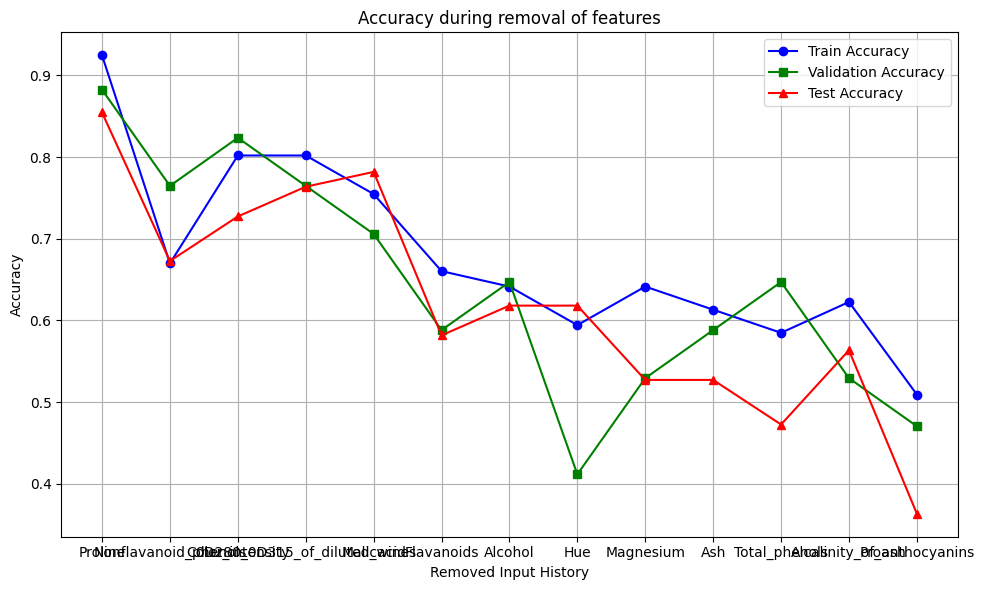

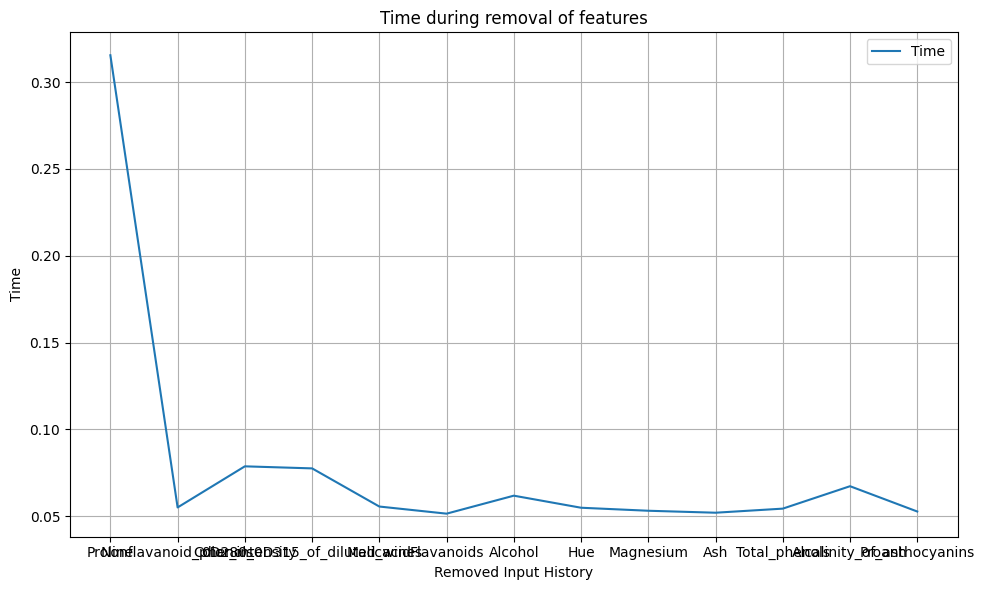

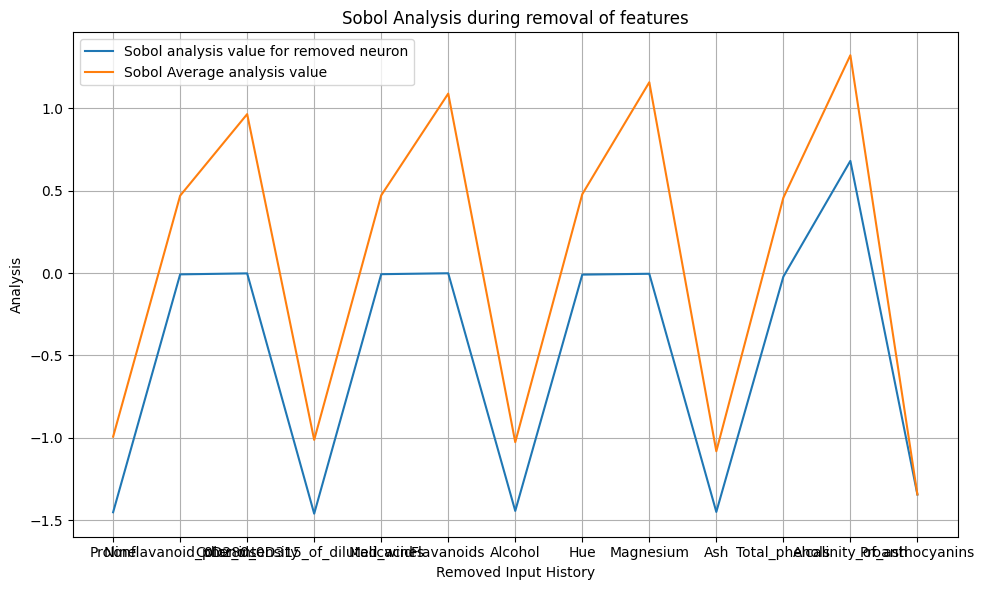

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
wine = fetch_ucirepo(id=109)
wine.data.targets['class'] = wine.data.targets['class'] - 1

X = wine.data.features
y = wine.data.targets

hidden_dim = 64
removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

<ipython-input-20-743363260cba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.9444, Training Accuracy: 0.8208, Valid Accuracy: 0.7647, Test Accuracy: 0.8000
[Sobol] Dropping neuron with index 36 |  Sobol value =  -1.28598 | Avg Sobol value: -0.82765

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.9905, Training Accuracy: 0.6698, Valid Accuracy: 0.7059, Test Accuracy: 0.6545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 41 |  Sobol value =  -0.00384 | Avg Sobol value: 0.49364

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.9638, Training Accuracy: 0.6226, Valid Accuracy: 0.7059, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 50 |  Sobol value =  -0.01063 | Avg Sobol value: 0.91145

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.9955, Training Accuracy: 0.8962, Valid Accuracy: 0.8824, Test Accuracy: 0.9091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 45 |  Sobol value =  -1.34192 | Avg Sobol value: -0.87429

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.9957, Training Accuracy: 0.8679, Valid Accuracy: 0.8235, Test Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 46 |  Sobol value =  -0.01815 | Avg Sobol value: 0.37508

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.9695, Training Accuracy: 0.9528, Valid Accuracy: 1.0000, Test Accuracy: 0.9091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 26 |  Sobol value =  -0.01823 | Avg Sobol value: 0.71172

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.8969, Training Accuracy: 0.6887, Valid Accuracy: 0.7647, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 33 |  Sobol value =  -1.38073 | Avg Sobol value: -0.90507

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 1.0315, Training Accuracy: 0.6415, Valid Accuracy: 0.7059, Test Accuracy: 0.6364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 26 |  Sobol value =  -0.00293 | Avg Sobol value: 0.47894

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.9802, Training Accuracy: 0.9151, Valid Accuracy: 0.8235, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 14 |  Sobol value =  -0.01592 | Avg Sobol value: 0.75995

---------------------------------------- Iteration 10 ----------------------------------------
Loss: 0.9925, Training Accuracy: 0.8679, Valid Accuracy: 0.7647, Test Accuracy: 0.8909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 48 |  Sobol value =  -1.26512 | Avg Sobol value: -0.83703

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 1.0160, Training Accuracy: 0.8491, Valid Accuracy: 0.8824, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 4 |  Sobol value =  -0.15961 | Avg Sobol value: 0.27316

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.9592, Training Accuracy: 0.6509, Valid Accuracy: 0.6471, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 20 |  Sobol value =  -0.01245 | Avg Sobol value: 0.84904

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 1.0494, Training Accuracy: 0.6792, Valid Accuracy: 0.7647, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 43 |  Sobol value =  -1.31996 | Avg Sobol value: -0.88155

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 1.0158, Training Accuracy: 0.8585, Valid Accuracy: 0.8824, Test Accuracy: 0.7455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 28 |  Sobol value =  -0.06920 | Avg Sobol value: 0.34959

---------------------------------------- Iteration 15 ----------------------------------------
Loss: 0.9788, Training Accuracy: 0.8962, Valid Accuracy: 0.8824, Test Accuracy: 0.8364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 |  Sobol value =  -0.07588 | Avg Sobol value: 0.26994

---------------------------------------- Iteration 16 ----------------------------------------
Loss: 1.0419, Training Accuracy: 0.7925, Valid Accuracy: 0.7059, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 25 |  Sobol value =  -1.40418 | Avg Sobol value: -0.93816

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 1.0143, Training Accuracy: 0.6132, Valid Accuracy: 0.6471, Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 16 |  Sobol value =  -0.01760 | Avg Sobol value: 0.44912

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 1.0395, Training Accuracy: 0.8679, Valid Accuracy: 0.7059, Test Accuracy: 0.8727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 32 |  Sobol value =  -0.01937 | Avg Sobol value: 0.36494

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.9930, Training Accuracy: 0.8396, Valid Accuracy: 0.8235, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 19 |  Sobol value =  -1.01438 | Avg Sobol value: -0.66476

---------------------------------------- Iteration 20 ----------------------------------------
Loss: 0.9971, Training Accuracy: 0.8962, Valid Accuracy: 0.8824, Test Accuracy: 0.8545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 20 |  Sobol value =  -0.00785 | Avg Sobol value: 0.46764

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.9872, Training Accuracy: 0.8396, Valid Accuracy: 0.7647, Test Accuracy: 0.7818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 38 |  Sobol value =  -0.00976 | Avg Sobol value: 0.45040

---------------------------------------- Iteration 22 ----------------------------------------
Loss: 0.9740, Training Accuracy: 0.6698, Valid Accuracy: 0.7647, Test Accuracy: 0.5818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.40791 | Avg Sobol value: -0.94040

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 1.0567, Training Accuracy: 0.6792, Valid Accuracy: 0.5882, Test Accuracy: 0.6909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 8 |  Sobol value =  -0.00873 | Avg Sobol value: 0.46563

---------------------------------------- Iteration 24 ----------------------------------------
Loss: 0.9711, Training Accuracy: 0.6132, Valid Accuracy: 0.5294, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 |  Sobol value =  -0.00833 | Avg Sobol value: 0.94543

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 1.0558, Training Accuracy: 0.4623, Valid Accuracy: 0.4706, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  -1.41991 | Avg Sobol value: -0.95071

---------------------------------------- Iteration 26 ----------------------------------------
Loss: 0.9847, Training Accuracy: 0.6981, Valid Accuracy: 0.7059, Test Accuracy: 0.5818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 2 |  Sobol value =  -0.00679 | Avg Sobol value: 0.48821

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 1.0300, Training Accuracy: 0.4434, Valid Accuracy: 0.5294, Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 12 |  Sobol value =  -7.23410 | Avg Sobol value: -1.09422

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 0.9398, Training Accuracy: 0.8491, Valid Accuracy: 0.9412, Test Accuracy: 0.8364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 21 |  Sobol value =  -1.31051 | Avg Sobol value: -0.85752

---------------------------------------- Iteration 29 ----------------------------------------
Loss: 1.0166, Training Accuracy: 0.8019, Valid Accuracy: 0.7647, Test Accuracy: 0.7636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 14 |  Sobol value =  -0.01179 | Avg Sobol value: 0.48370

---------------------------------------- Iteration 30 ----------------------------------------
Loss: 0.9558, Training Accuracy: 0.3868, Valid Accuracy: 0.4118, Test Accuracy: 0.3273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 20 |  Sobol value =  -0.00262 | Avg Sobol value: 0.92676

---------------------------------------- Iteration 31 ----------------------------------------
Loss: 1.0322, Training Accuracy: 0.7075, Valid Accuracy: 0.7059, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.23295 | Avg Sobol value: -0.81948

---------------------------------------- Iteration 32 ----------------------------------------
Loss: 0.9678, Training Accuracy: 0.8491, Valid Accuracy: 0.8235, Test Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 25 |  Sobol value =  -0.03866 | Avg Sobol value: 0.39253

---------------------------------------- Iteration 33 ----------------------------------------
Loss: 1.0256, Training Accuracy: 0.6321, Valid Accuracy: 0.7059, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 |  Sobol value =  -0.00222 | Avg Sobol value: 0.97018

---------------------------------------- Iteration 34 ----------------------------------------
Loss: 1.0240, Training Accuracy: 0.6415, Valid Accuracy: 0.7059, Test Accuracy: 0.4545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 6 |  Sobol value =  -1.36776 | Avg Sobol value: -0.90900

---------------------------------------- Iteration 35 ----------------------------------------
Loss: 1.0744, Training Accuracy: 0.7075, Valid Accuracy: 0.5294, Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 19 |  Sobol value =  -0.12378 | Avg Sobol value: 0.18379

---------------------------------------- Iteration 36 ----------------------------------------
Loss: 1.0281, Training Accuracy: 0.8491, Valid Accuracy: 0.7647, Test Accuracy: 0.8727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 18 |  Sobol value =  -1.31806 | Avg Sobol value: -0.50429

---------------------------------------- Iteration 37 ----------------------------------------
Loss: 1.0520, Training Accuracy: 0.8208, Valid Accuracy: 0.8235, Test Accuracy: 0.7273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -0.69592 | Avg Sobol value: -0.45294

---------------------------------------- Iteration 38 ----------------------------------------
Loss: 1.0467, Training Accuracy: 0.6415, Valid Accuracy: 0.7059, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 20 |  Sobol value =  -0.02298 | Avg Sobol value: 0.36819

---------------------------------------- Iteration 39 ----------------------------------------
Loss: 1.0427, Training Accuracy: 0.4811, Valid Accuracy: 0.5294, Test Accuracy: 0.4909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 18 |  Sobol value =  -24.14850 | Avg Sobol value: -7.28842

---------------------------------------- Iteration 40 ----------------------------------------
Loss: 1.0668, Training Accuracy: 0.7453, Valid Accuracy: 0.7647, Test Accuracy: 0.7091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  -1.30401 | Avg Sobol value: -0.86719

---------------------------------------- Iteration 41 ----------------------------------------
Loss: 1.0562, Training Accuracy: 0.4623, Valid Accuracy: 0.5294, Test Accuracy: 0.4727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  -0.01996 | Avg Sobol value: 0.46716

---------------------------------------- Iteration 42 ----------------------------------------
Loss: 1.0464, Training Accuracy: 0.6415, Valid Accuracy: 0.6471, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 |  Sobol value =  -7.70445 | Avg Sobol value: -1.29984

---------------------------------------- Iteration 43 ----------------------------------------
Loss: 1.0343, Training Accuracy: 0.8113, Valid Accuracy: 0.7647, Test Accuracy: 0.9091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 19 |  Sobol value =  -1.06388 | Avg Sobol value: -0.69775

---------------------------------------- Iteration 44 ----------------------------------------
Loss: 0.9977, Training Accuracy: 0.3585, Valid Accuracy: 0.3529, Test Accuracy: 0.2727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 16 |  Sobol value =  -0.00341 | Avg Sobol value: 0.47414

---------------------------------------- Iteration 45 ----------------------------------------
Loss: 1.0687, Training Accuracy: 0.4245, Valid Accuracy: 0.4118, Test Accuracy: 0.4727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -9.45536 | Avg Sobol value: -2.38170

---------------------------------------- Iteration 46 ----------------------------------------
Loss: 1.0215, Training Accuracy: 0.6698, Valid Accuracy: 0.6471, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.33793 | Avg Sobol value: -0.89934

---------------------------------------- Iteration 47 ----------------------------------------
Loss: 1.0096, Training Accuracy: 0.6887, Valid Accuracy: 0.6471, Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  -0.01314 | Avg Sobol value: 0.32443

---------------------------------------- Iteration 48 ----------------------------------------
Loss: 1.0570, Training Accuracy: 0.5943, Valid Accuracy: 0.5294, Test Accuracy: 0.4545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 8 |  Sobol value =  0.00108 | Avg Sobol value: 0.94255

---------------------------------------- Iteration 49 ----------------------------------------
Loss: 1.0420, Training Accuracy: 0.3774, Valid Accuracy: 0.4118, Test Accuracy: 0.4364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 10 |  Sobol value =  -1.44689 | Avg Sobol value: -0.98759

---------------------------------------- Iteration 50 ----------------------------------------
Loss: 1.0916, Training Accuracy: 0.3774, Valid Accuracy: 0.2941, Test Accuracy: 0.4727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 14 |  Sobol value =  -0.01156 | Avg Sobol value: 0.46699

---------------------------------------- Iteration 51 ----------------------------------------
Loss: 1.0753, Training Accuracy: 0.6038, Valid Accuracy: 0.7059, Test Accuracy: 0.6909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 6 |  Sobol value =  -1.32341 | Avg Sobol value: 0.23554

---------------------------------------- Iteration 52 ----------------------------------------
Loss: 0.9884, Training Accuracy: 0.3585, Valid Accuracy: 0.3529, Test Accuracy: 0.2727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.47788 | Avg Sobol value: -1.01937

---------------------------------------- Iteration 53 ----------------------------------------
Loss: 1.0795, Training Accuracy: 0.3396, Valid Accuracy: 0.2941, Test Accuracy: 0.3091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  -0.02300 | Avg Sobol value: 0.39769

---------------------------------------- Iteration 54 ----------------------------------------
Loss: 1.0730, Training Accuracy: 0.6226, Valid Accuracy: 0.5294, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 5 |  Sobol value =  0.00484 | Avg Sobol value: 0.86662

---------------------------------------- Iteration 55 ----------------------------------------
Loss: 1.0425, Training Accuracy: 0.7075, Valid Accuracy: 0.5294, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 4 |  Sobol value =  -1.19458 | Avg Sobol value: -0.80753

---------------------------------------- Iteration 56 ----------------------------------------
Loss: 1.0585, Training Accuracy: 0.6887, Valid Accuracy: 0.6471, Test Accuracy: 0.6909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 2 |  Sobol value =  0.00363 | Avg Sobol value: 0.20236

---------------------------------------- Iteration 57 ----------------------------------------
Loss: 1.0932, Training Accuracy: 0.4245, Valid Accuracy: 0.3529, Test Accuracy: 0.3455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.05294 | Avg Sobol value: 0.58961

---------------------------------------- Iteration 58 ----------------------------------------
Loss: 1.0745, Training Accuracy: 0.3774, Valid Accuracy: 0.4118, Test Accuracy: 0.4364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.46147 | Avg Sobol value: -1.03795

---------------------------------------- Iteration 59 ----------------------------------------
Loss: 1.0927, Training Accuracy: 0.2642, Valid Accuracy: 0.2353, Test Accuracy: 0.2909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  -0.00626 | Avg Sobol value: 0.47909

---------------------------------------- Iteration 60 ----------------------------------------
Loss: 1.0244, Training Accuracy: 0.3774, Valid Accuracy: 0.4118, Test Accuracy: 0.4364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 0 |  Sobol value =  -16.24213 | Avg Sobol value: -6.00834

---------------------------------------- Iteration 61 ----------------------------------------
Loss: 1.0503, Training Accuracy: 0.3491, Valid Accuracy: 0.4118, Test Accuracy: 0.3818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  -1.37118 | Avg Sobol value: -1.02150

---------------------------------------- Iteration 62 ----------------------------------------
Loss: 1.1205, Training Accuracy: 0.2642, Valid Accuracy: 0.2353, Test Accuracy: 0.2909
[Sobol] Dropping neuron with index 2 |  Sobol value =  -0.00619 | Avg Sobol value: 0.48386

---------------------------------------- Iteration 63 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 1.1009, Training Accuracy: 0.3774, Valid Accuracy: 0.4118, Test Accuracy: 0.4364
[Sobol] Dropping neuron with index 1 |  Sobol value =  0.39459 | Avg Sobol value: 0.53350

---------------------------------------- Iteration 64 ----------------------------------------
Loss: 0.9800, Training Accuracy: 0.5566, Valid Accuracy: 0.5882, Test Accuracy: 0.4727
[Sobol] Dropping neuron with index 0 |  Sobol value =  -1.37201 | Avg Sobol value: -1.37201



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


removed_inputs_history:
[36, 41, 50, 45, 46, 26, 33, 26, 14, 48, 4, 20, 43, 28, 3, 25, 16, 32, 19, 20, 38, 0, 8, 17, 7, 2, 12, 21, 14, 20, 0, 25, 17, 6, 19, 18, 0, 20, 18, 1, 7, 3, 19, 16, 0, 0, 7, 8, 10, 14, 6, 0, 1, 5, 4, 2, 0, 0, 1, 0, 1, 2, 1, 0]
train_accuracy_history:
[0.8207547169811321, 0.6698113207547169, 0.6226415094339622, 0.8962264150943396, 0.8679245283018868, 0.9528301886792453, 0.6886792452830188, 0.6415094339622641, 0.9150943396226415, 0.8679245283018868, 0.8490566037735849, 0.6509433962264151, 0.6792452830188679, 0.8584905660377359, 0.8962264150943396, 0.7924528301886793, 0.6132075471698113, 0.8679245283018868, 0.839622641509434, 0.8962264150943396, 0.839622641509434, 0.6698113207547169, 0.6792452830188679, 0.6132075471698113, 0.46226415094339623, 0.6981132075471698, 0.44339622641509435, 0.8490566037735849, 0.8018867924528302, 0.3867924528301887, 0.7075471698113207, 0.8490566037735849, 0.6320754716981132, 0.6415094339622641, 0.7075471698113207, 0.8490566037735849, 0.82

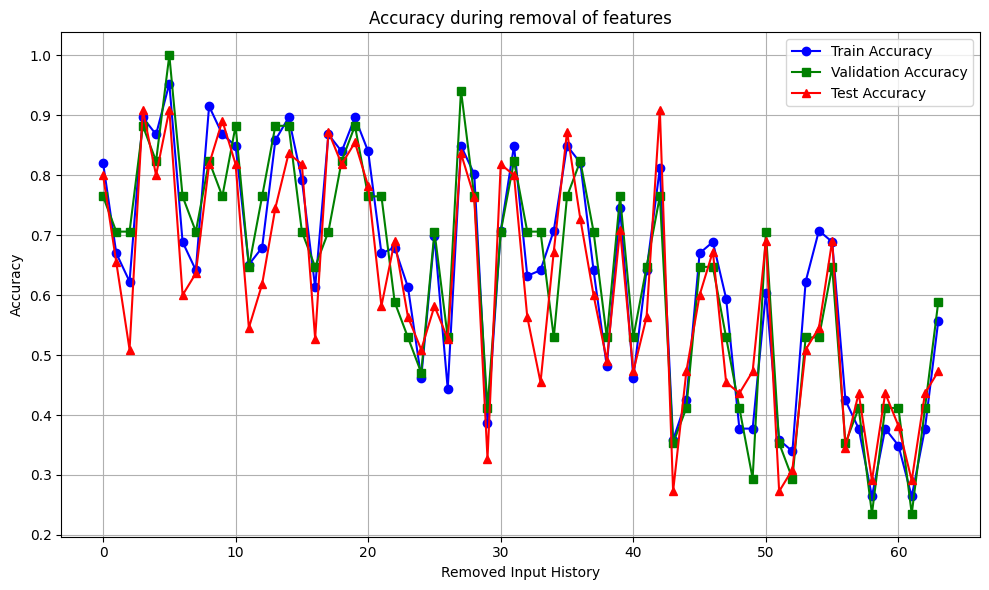

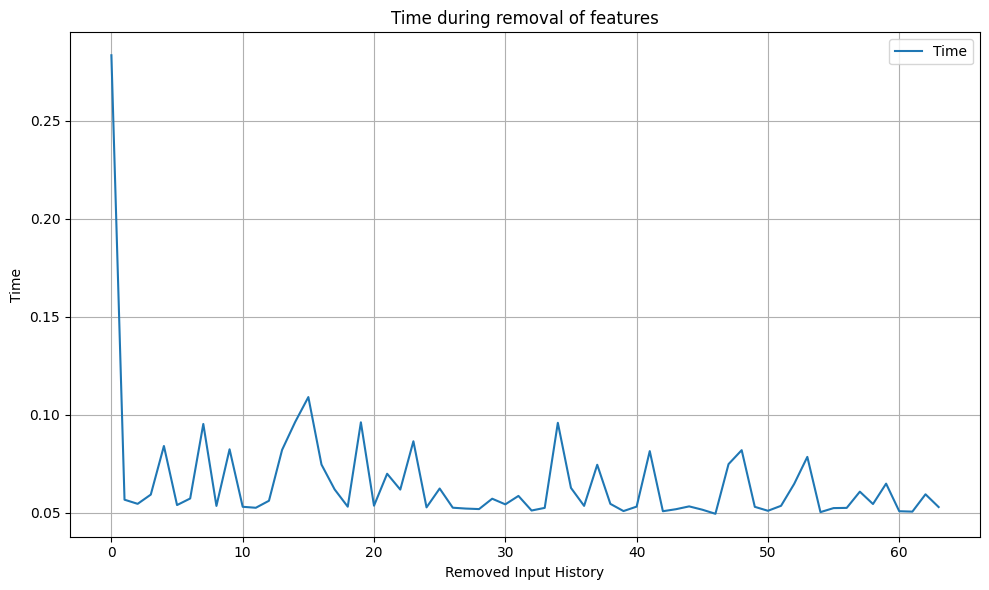

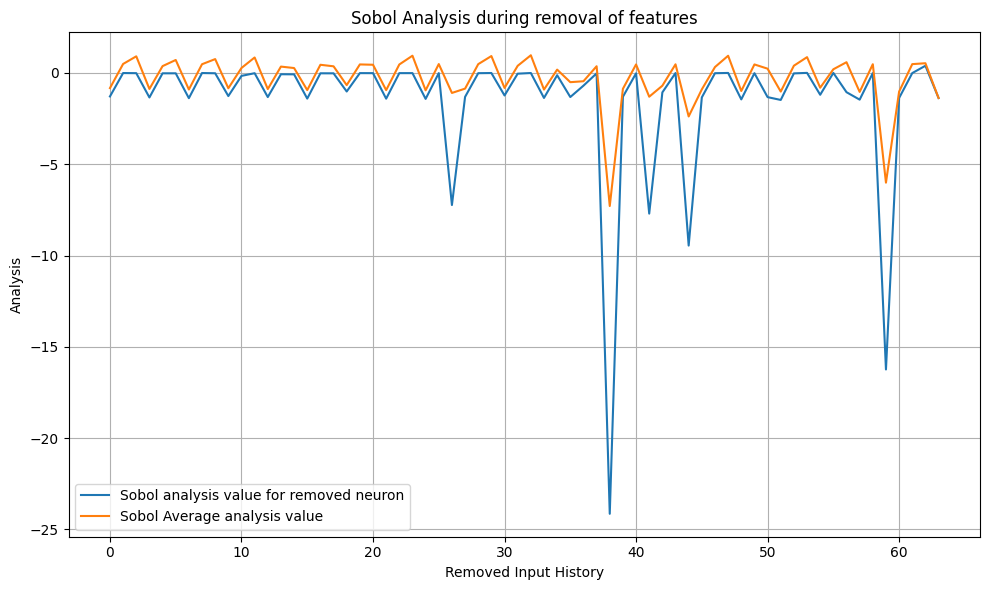

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
wine = fetch_ucirepo(id=109)
wine.data.targets['class'] = wine.data.targets['class'] - 1

X = wine.data.features
y = wine.data.targets

hidden_dim = 64

removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

<ipython-input-22-a9e3022f32ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.9813, Training Accuracy: 0.9717, Valid Accuracy: 1.0000, , Test Accuracy: 0.9455
[PAWN] Dropping neuron with index 0 (column: Alcohol) |  PAWN value =  0.84802 | Avg PAWN value: 0.00031 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.9237, Training Accuracy: 0.7547, Valid Accuracy: 0.7059, , Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: Malicacid) |  PAWN value =  0.80191 | Avg PAWN value: 0.01257 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.9201, Training Accuracy: 0.8679, Valid Accuracy: 0.8235, , Test Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: Ash) |  PAWN value =  1.33243 | Avg PAWN value: 0.00004 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.9294, Training Accuracy: 0.6415, Valid Accuracy: 0.5882, , Test Accuracy: 0.5818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 (column: Nonflavanoid_phenols) |  PAWN value =  0.67592 | Avg PAWN value: 0.00176 

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.9304, Training Accuracy: 0.8396, Valid Accuracy: 0.7647, , Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 (column: Magnesium) |  PAWN value =  0.83698 | Avg PAWN value: 0.05012 

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.9524, Training Accuracy: 0.8679, Valid Accuracy: 0.9412, , Test Accuracy: 0.8909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 (column: Hue) |  PAWN value =  0.66447 | Avg PAWN value: 0.09180 

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.9066, Training Accuracy: 0.7925, Valid Accuracy: 0.8824, , Test Accuracy: 0.7636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: Alcalinity_of_ash) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 1.0179, Training Accuracy: 0.8396, Valid Accuracy: 0.7647, , Test Accuracy: 0.8364
[PAWN] Dropping neuron with index 0 (column: Total_phenols) |  PAWN value =  0.63826 | Avg PAWN value: 0.00028 

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.9459, Training Accuracy: 0.9434, Valid Accuracy: 0.9412, , Test Accuracy: 0.8727
[PAWN] Dropping neuron with index 0 (column: Flavanoids) |  PAWN value =  0.74924 | Avg PAWN value: 0.00016 

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.9629, Training Accuracy: 0.6604, Valid Accuracy: 0.6471, , Test Accuracy: 0.5636
[PAWN] Dropping neuron with index 2 (column: 0D280_0D315_of_diluted_wines) |  PAWN value =  0.76562 | Avg PAWN value: 0.09612 

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.8961, Training Accuracy: 0.7642, Valid Accuracy: 0.8235, , Test Accuracy: 0.7091
[PAWN] Dropping neuron with index 0 (column: Proanthocyanins) |  PAWN value =  0.75116 | Avg PAWN value: 0.00049 

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.9343, Training Accuracy: 0.7642, Valid Accuracy: 0.8235, , Test Accuracy: 0.8364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: Color_intensity) |  PAWN value =  0.63307 | Avg PAWN value: 0.26213 

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 0.7902, Training Accuracy: 0.7075, Valid Accuracy: 0.7647, , Test Accuracy: 0.6364
[PAWN] Dropping neuron with index 0 (column: Proline) |  PAWN value =  1.33243 | Avg PAWN value: 0.00073 



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


removed_inputs_history:
['Alcohol', 'Malicacid', 'Ash', 'Nonflavanoid_phenols', 'Magnesium', 'Hue', 'Alcalinity_of_ash', 'Total_phenols', 'Flavanoids', '0D280_0D315_of_diluted_wines', 'Proanthocyanins', 'Color_intensity', 'Proline']
train_accuracy_history:
[0.9716981132075472, 0.7547169811320755, 0.8679245283018868, 0.6415094339622641, 0.839622641509434, 0.8679245283018868, 0.7924528301886793, 0.839622641509434, 0.9433962264150944, 0.660377358490566, 0.7641509433962265, 0.7641509433962265, 0.7075471698113207]
valid_accuracy_history:
[1.0, 0.7058823529411765, 0.8235294117647058, 0.5882352941176471, 0.7647058823529411, 0.9411764705882353, 0.8823529411764706, 0.7647058823529411, 0.9411764705882353, 0.6470588235294118, 0.8235294117647058, 0.8235294117647058, 0.7647058823529411]
test_accuracy_history:
[0.9454545454545454, 0.6727272727272727, 0.8, 0.5818181818181818, 0.8181818181818182, 0.8909090909090909, 0.7636363636363637, 0.8363636363636363, 0.8727272727272727, 0.5636363636363636, 0.7090

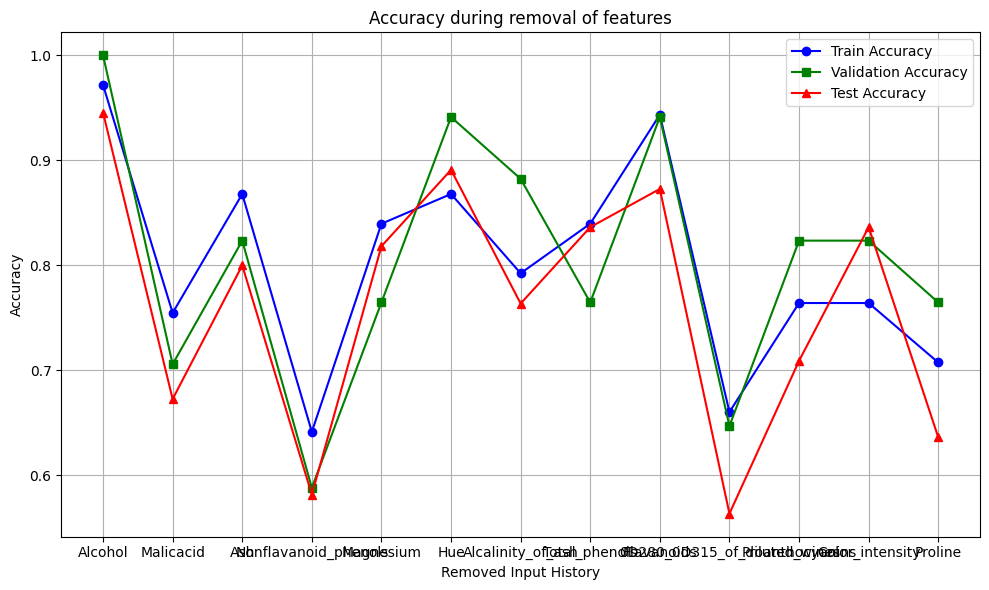

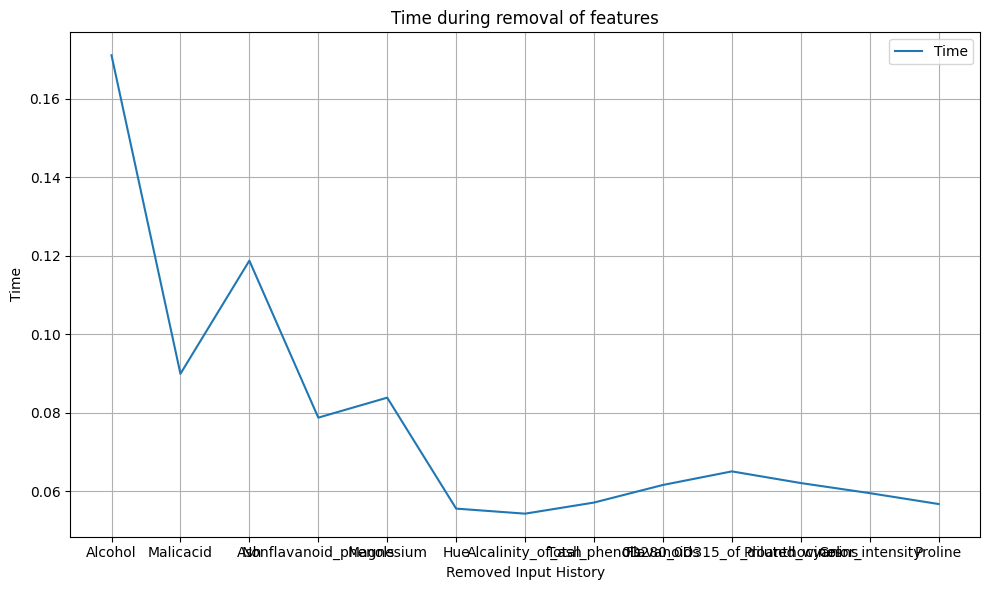

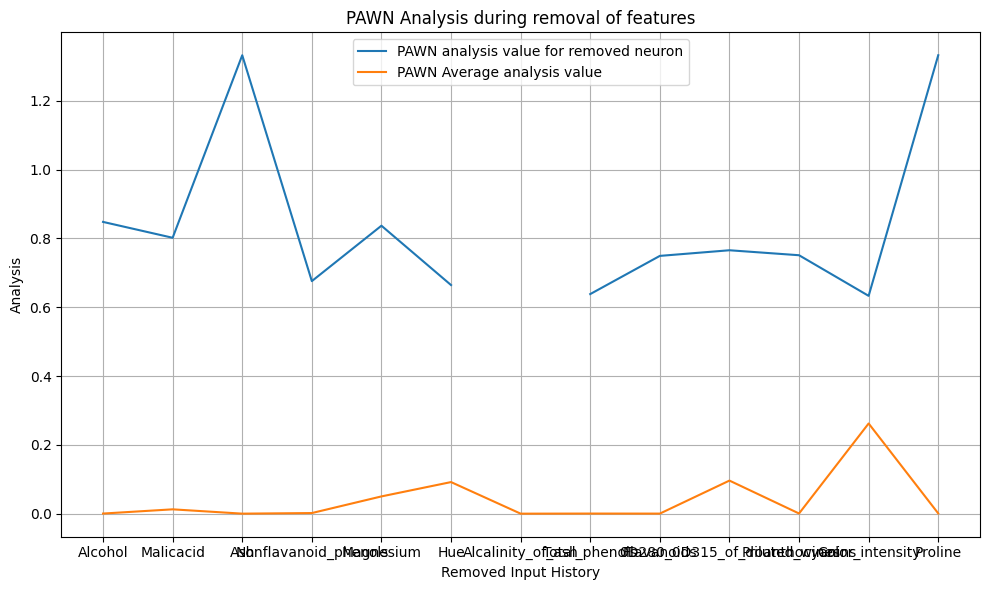

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
wine = fetch_ucirepo(id=109)
wine.data.targets['class'] = wine.data.targets['class'] - 1

X = wine.data.features
y = wine.data.targets

hidden_dim = 64


removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

<ipython-input-24-9393bc51d959>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine.data.targets['class'] = wine.data.targets['class'] - 1
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.9673, Training Accuracy: 0.8302, Valid Accuracy: 0.8235, Test Accuracy: 0.8364
[PAWN] Dropping neuron with index 62 |  PAWN value =  0.00440 | Avg PAWN value: 0.02774 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.8904, Training Accuracy: 0.8774, Valid Accuracy: 0.7647, Test Accuracy: 0.8909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 50 |  PAWN value =  0.00711 | Avg PAWN value: 0.03293 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 1.0130, Training Accuracy: 0.7925, Valid Accuracy: 0.7059, Test Accuracy: 0.7091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.00538 | Avg PAWN value: 0.03328 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 1.0083, Training Accuracy: 0.8679, Valid Accuracy: 0.8235, Test Accuracy: 0.8545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 29 |  PAWN value =  0.00668 | Avg PAWN value: 0.02050 

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.9965, Training Accuracy: 0.6698, Valid Accuracy: 0.5882, Test Accuracy: 0.6545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 34 |  PAWN value =  0.00016 | Avg PAWN value: 0.00039 

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.9887, Training Accuracy: 0.8868, Valid Accuracy: 0.9412, Test Accuracy: 0.8182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 32 |  PAWN value =  0.00786 | Avg PAWN value: 0.02780 

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 1.0309, Training Accuracy: 0.6415, Valid Accuracy: 0.5294, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.00018 | Avg PAWN value: 0.00043 

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 0.9681, Training Accuracy: 0.6887, Valid Accuracy: 0.7059, Test Accuracy: 0.6545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 11 |  PAWN value =  0.00021 | Avg PAWN value: 0.00063 

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.9675, Training Accuracy: 0.8302, Valid Accuracy: 0.8235, Test Accuracy: 0.7455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 28 |  PAWN value =  0.00556 | Avg PAWN value: 0.02810 

---------------------------------------- Iteration 10 ----------------------------------------
Loss: 0.9826, Training Accuracy: 0.6321, Valid Accuracy: 0.5882, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 31 |  PAWN value =  0.00004 | Avg PAWN value: 0.00010 

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.9477, Training Accuracy: 0.7736, Valid Accuracy: 0.7647, Test Accuracy: 0.8000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 52 |  PAWN value =  0.00400 | Avg PAWN value: 0.01667 

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.9846, Training Accuracy: 0.9151, Valid Accuracy: 0.9412, Test Accuracy: 0.8909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 33 |  PAWN value =  0.00086 | Avg PAWN value: 0.00261 

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 1.0188, Training Accuracy: 0.4811, Valid Accuracy: 0.4118, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00001 | Avg PAWN value: 0.00001 

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 0.9292, Training Accuracy: 0.9340, Valid Accuracy: 0.9412, Test Accuracy: 0.8909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 11 |  PAWN value =  0.00552 | Avg PAWN value: 0.02814 

---------------------------------------- Iteration 15 ----------------------------------------
Loss: 0.9964, Training Accuracy: 0.6887, Valid Accuracy: 0.7059, Test Accuracy: 0.6364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 |  PAWN value =  0.00033 | Avg PAWN value: 0.00060 

---------------------------------------- Iteration 16 ----------------------------------------
Loss: 0.9767, Training Accuracy: 0.8679, Valid Accuracy: 0.8824, Test Accuracy: 0.8545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.00556 | Avg PAWN value: 0.01393 

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 1.0504, Training Accuracy: 0.6887, Valid Accuracy: 0.7647, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00085 | Avg PAWN value: 0.00239 

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 1.0001, Training Accuracy: 0.6509, Valid Accuracy: 0.6471, Test Accuracy: 0.6545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00013 | Avg PAWN value: 0.00028 

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.9609, Training Accuracy: 0.7358, Valid Accuracy: 0.7059, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 25 |  PAWN value =  0.00439 | Avg PAWN value: 0.01916 

---------------------------------------- Iteration 20 ----------------------------------------
Loss: 0.9552, Training Accuracy: 0.7170, Valid Accuracy: 0.7059, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 20 |  PAWN value =  0.00138 | Avg PAWN value: 0.00254 

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.9871, Training Accuracy: 0.6698, Valid Accuracy: 0.6471, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 37 |  PAWN value =  0.00049 | Avg PAWN value: 0.00106 

---------------------------------------- Iteration 22 ----------------------------------------
Loss: 1.0075, Training Accuracy: 0.8113, Valid Accuracy: 0.8235, Test Accuracy: 0.7455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 13 |  PAWN value =  0.00575 | Avg PAWN value: 0.03047 

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 1.0410, Training Accuracy: 0.8113, Valid Accuracy: 0.8235, Test Accuracy: 0.7818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 20 |  PAWN value =  0.00636 | Avg PAWN value: 0.03549 

---------------------------------------- Iteration 24 ----------------------------------------
Loss: 0.9894, Training Accuracy: 0.6415, Valid Accuracy: 0.5882, Test Accuracy: 0.4364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 30 |  PAWN value =  0.00210 | Avg PAWN value: 0.01685 

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 0.9412, Training Accuracy: 0.5943, Valid Accuracy: 0.4706, Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.00031 | Avg PAWN value: 0.00092 

---------------------------------------- Iteration 26 ----------------------------------------
Loss: 1.0273, Training Accuracy: 0.6887, Valid Accuracy: 0.7059, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 15 |  PAWN value =  0.00192 | Avg PAWN value: 0.00477 

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 1.0498, Training Accuracy: 0.6321, Valid Accuracy: 0.6471, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 27 |  PAWN value =  0.00660 | Avg PAWN value: 0.03843 

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 1.0011, Training Accuracy: 0.7453, Valid Accuracy: 0.7059, Test Accuracy: 0.7091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 18 |  PAWN value =  0.01433 | Avg PAWN value: 0.04769 

---------------------------------------- Iteration 29 ----------------------------------------
Loss: 1.0055, Training Accuracy: 0.8491, Valid Accuracy: 0.8235, Test Accuracy: 0.9091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 30 |  PAWN value =  0.00187 | Avg PAWN value: 0.01023 

---------------------------------------- Iteration 30 ----------------------------------------
Loss: 0.9870, Training Accuracy: 0.7170, Valid Accuracy: 0.6471, Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 9 |  PAWN value =  0.00556 | Avg PAWN value: 0.03402 

---------------------------------------- Iteration 31 ----------------------------------------
Loss: 1.0313, Training Accuracy: 0.6321, Valid Accuracy: 0.5882, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 11 |  PAWN value =  0.00585 | Avg PAWN value: 0.04121 

---------------------------------------- Iteration 32 ----------------------------------------
Loss: 1.0550, Training Accuracy: 0.4811, Valid Accuracy: 0.4706, Test Accuracy: 0.4364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 29 |  PAWN value =  0.00092 | Avg PAWN value: 0.00335 

---------------------------------------- Iteration 33 ----------------------------------------
Loss: 1.0386, Training Accuracy: 0.7075, Valid Accuracy: 0.7059, Test Accuracy: 0.7455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 24 |  PAWN value =  0.00635 | Avg PAWN value: 0.02406 

---------------------------------------- Iteration 34 ----------------------------------------
Loss: 1.0364, Training Accuracy: 0.6038, Valid Accuracy: 0.5294, Test Accuracy: 0.7273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.00194 | Avg PAWN value: 0.00504 

---------------------------------------- Iteration 35 ----------------------------------------
Loss: 1.0294, Training Accuracy: 0.8113, Valid Accuracy: 0.7059, Test Accuracy: 0.7273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.01298 | Avg PAWN value: 0.04034 

---------------------------------------- Iteration 36 ----------------------------------------
Loss: 1.0041, Training Accuracy: 0.3868, Valid Accuracy: 0.4706, Test Accuracy: 0.2909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 9 |  PAWN value =  0.00125 | Avg PAWN value: 0.00384 

---------------------------------------- Iteration 37 ----------------------------------------
Loss: 1.0478, Training Accuracy: 0.6321, Valid Accuracy: 0.5294, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 26 |  PAWN value =  0.00612 | Avg PAWN value: 0.04450 

---------------------------------------- Iteration 38 ----------------------------------------
Loss: 1.0699, Training Accuracy: 0.7358, Valid Accuracy: 0.8235, Test Accuracy: 0.6727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 |  PAWN value =  0.01007 | Avg PAWN value: 0.04381 

---------------------------------------- Iteration 39 ----------------------------------------
Loss: 1.0554, Training Accuracy: 0.5094, Valid Accuracy: 0.5882, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 14 |  PAWN value =  0.00686 | Avg PAWN value: 0.03095 

---------------------------------------- Iteration 40 ----------------------------------------
Loss: 0.9710, Training Accuracy: 0.5943, Valid Accuracy: 0.6471, Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.00038 | Avg PAWN value: 0.00072 

---------------------------------------- Iteration 41 ----------------------------------------
Loss: 1.0270, Training Accuracy: 0.7075, Valid Accuracy: 0.7059, Test Accuracy: 0.6182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00654 | Avg PAWN value: 0.05160 

---------------------------------------- Iteration 42 ----------------------------------------
Loss: 1.0335, Training Accuracy: 0.6226, Valid Accuracy: 0.5882, Test Accuracy: 0.5818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 21 |  PAWN value =  0.00508 | Avg PAWN value: 0.04350 

---------------------------------------- Iteration 43 ----------------------------------------
Loss: 1.0861, Training Accuracy: 0.5849, Valid Accuracy: 0.5294, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00717 | Avg PAWN value: 0.02817 

---------------------------------------- Iteration 44 ----------------------------------------
Loss: 1.0457, Training Accuracy: 0.6887, Valid Accuracy: 0.5882, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00808 | Avg PAWN value: 0.02937 

---------------------------------------- Iteration 45 ----------------------------------------
Loss: 1.0651, Training Accuracy: 0.7925, Valid Accuracy: 0.8824, Test Accuracy: 0.8364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 10 |  PAWN value =  0.00742 | Avg PAWN value: 0.03324 

---------------------------------------- Iteration 46 ----------------------------------------
Loss: 1.0401, Training Accuracy: 0.6321, Valid Accuracy: 0.7647, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 10 |  PAWN value =  0.00549 | Avg PAWN value: 0.05316 

---------------------------------------- Iteration 47 ----------------------------------------
Loss: 1.0141, Training Accuracy: 0.6415, Valid Accuracy: 0.7647, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00745 | Avg PAWN value: 0.03944 

---------------------------------------- Iteration 48 ----------------------------------------
Loss: 1.0440, Training Accuracy: 0.7830, Valid Accuracy: 0.7059, Test Accuracy: 0.7091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.01867 | Avg PAWN value: 0.05918 

---------------------------------------- Iteration 49 ----------------------------------------
Loss: 1.0016, Training Accuracy: 0.7264, Valid Accuracy: 0.6471, Test Accuracy: 0.7455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00291 | Avg PAWN value: 0.00723 

---------------------------------------- Iteration 50 ----------------------------------------
Loss: 1.0522, Training Accuracy: 0.3774, Valid Accuracy: 0.4706, Test Accuracy: 0.4182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.00198 | Avg PAWN value: 0.00605 

---------------------------------------- Iteration 51 ----------------------------------------
Loss: 1.0825, Training Accuracy: 0.6321, Valid Accuracy: 0.5882, Test Accuracy: 0.5273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 9 |  PAWN value =  0.02081 | Avg PAWN value: 0.07157 

---------------------------------------- Iteration 52 ----------------------------------------
Loss: 1.0583, Training Accuracy: 0.6132, Valid Accuracy: 0.4706, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00625 | Avg PAWN value: 0.01724 

---------------------------------------- Iteration 53 ----------------------------------------
Loss: 1.0968, Training Accuracy: 0.4245, Valid Accuracy: 0.4118, Test Accuracy: 0.5455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 |  PAWN value =  0.00019 | Avg PAWN value: 0.00029 

---------------------------------------- Iteration 54 ----------------------------------------
Loss: 1.0545, Training Accuracy: 0.5566, Valid Accuracy: 0.4706, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.01463 | Avg PAWN value: 0.07724 

---------------------------------------- Iteration 55 ----------------------------------------
Loss: 1.0417, Training Accuracy: 0.6132, Valid Accuracy: 0.5294, Test Accuracy: 0.5636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.00845 | Avg PAWN value: 0.03703 

---------------------------------------- Iteration 56 ----------------------------------------
Loss: 1.0974, Training Accuracy: 0.2075, Valid Accuracy: 0.3529, Test Accuracy: 0.2000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.00589 | Avg PAWN value: 0.02151 

---------------------------------------- Iteration 57 ----------------------------------------
Loss: 1.0638, Training Accuracy: 0.5094, Valid Accuracy: 0.4706, Test Accuracy: 0.6000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.00786 | Avg PAWN value: 0.07668 

---------------------------------------- Iteration 58 ----------------------------------------
Loss: 1.0962, Training Accuracy: 0.5094, Valid Accuracy: 0.3529, Test Accuracy: 0.4182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.00884 | Avg PAWN value: 0.06745 

---------------------------------------- Iteration 59 ----------------------------------------
Loss: 1.0813, Training Accuracy: 0.3679, Valid Accuracy: 0.4118, Test Accuracy: 0.4545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.00601 | Avg PAWN value: 0.01229 

---------------------------------------- Iteration 60 ----------------------------------------
Loss: 1.0367, Training Accuracy: 0.5472, Valid Accuracy: 0.5882, Test Accuracy: 0.5091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.01147 | Avg PAWN value: 0.02471 

---------------------------------------- Iteration 61 ----------------------------------------
Loss: 1.0562, Training Accuracy: 0.4811, Valid Accuracy: 0.5294, Test Accuracy: 0.4727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.01586 | Avg PAWN value: 0.08787 

---------------------------------------- Iteration 62 ----------------------------------------
Loss: 1.0945, Training Accuracy: 0.2736, Valid Accuracy: 0.2353, Test Accuracy: 0.3636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.00697 | Avg PAWN value: 0.00898 

---------------------------------------- Iteration 63 ----------------------------------------
Loss: 1.0918, Training Accuracy: 0.3774, Valid Accuracy: 0.4118, Test Accuracy: 0.4364
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00000 | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 64 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 1.0027, Training Accuracy: 0.5094, Valid Accuracy: 0.5294, Test Accuracy: 0.5636
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.11353 | Avg PAWN value: 0.11353 



removed_inputs_history:
[62, 50, 1, 29, 34, 32, 6, 11, 28, 31, 52, 33, 0, 11, 5, 1, 4, 0, 25, 20, 37, 13, 20, 30, 2, 15, 27, 18, 30, 9, 11, 29, 24, 3, 4, 9, 26, 5, 14, 6, 0, 21, 4, 0, 10, 10, 4, 6, 0, 3, 9, 4, 5, 4, 2, 1, 3, 3, 2, 3, 1, 2, 0, 0]
train_accuracy_history:
[0.8301886792452831, 0.8773584905660378, 0.7924528301886793, 0.8679245283018868, 0.6698113207547169, 0.8867924528301887, 0.6415094339622641, 0.6886792452830188, 0.8301886792452831, 0.6320754716981132, 0.7735849056603774, 0.9150943396226415, 0.4811320754716981, 0.9339622641509434, 0.6886792452830188, 0.8679245283018868, 0.6886792452830188, 0.6509433962264151, 0.7358490566037735, 0.7169811320754716, 0.6698113207547169, 0.8113207547169812, 0.8113207547169812, 0.6415094339622641, 0.5943396226415094, 0.6886792452830188, 0.6320754716981132, 0.7452830188679245, 0.8490566037735849, 0.7169811320754716, 0.6320754716981132, 0.4811320754716981, 0.7075471698113207, 0.6037735849056604, 0.8113207547169812, 0.3867924528301887, 0.6320754

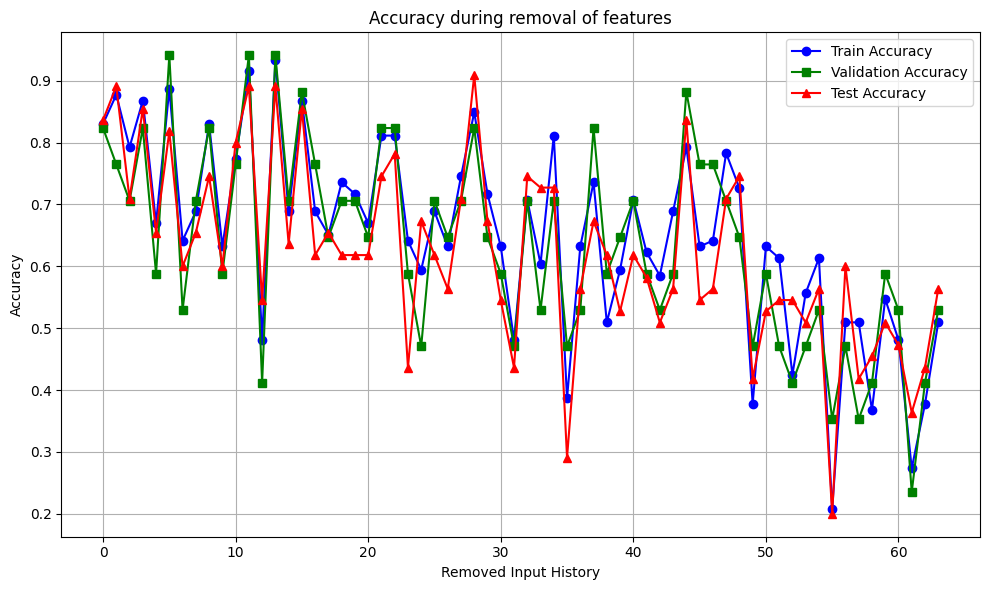

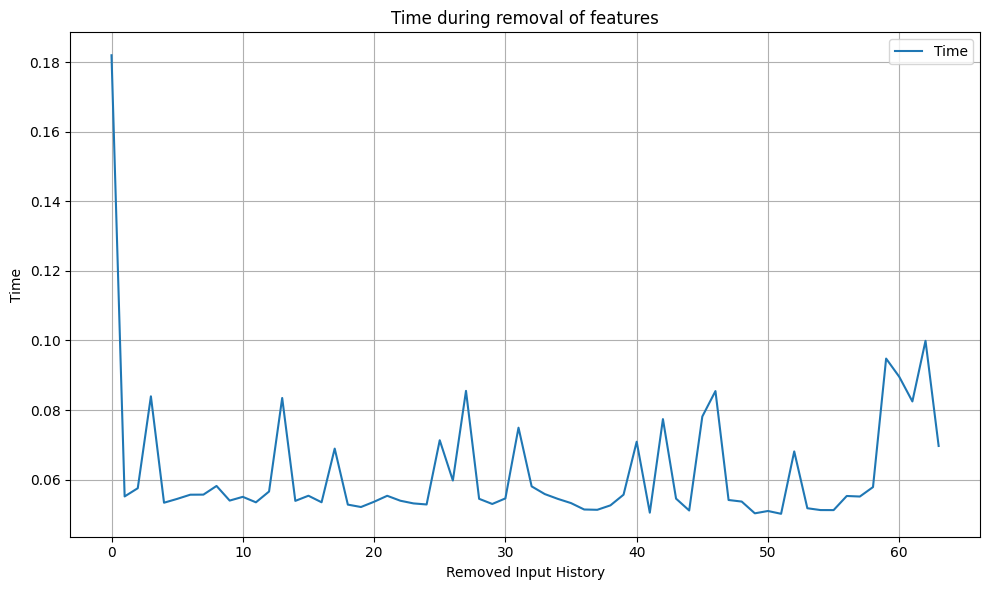

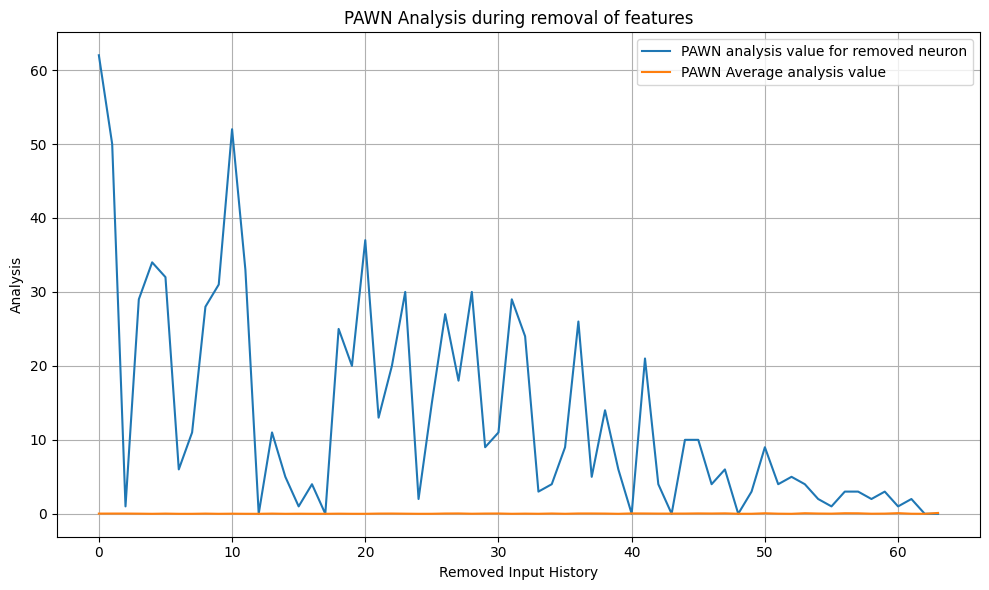

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")